In [2]:
# Loads the package
! pip install -q 'gwosc==0.5.4'
! pip install pycbc
! pip install -q gwpy

Reason for being yanked: Metadata is broken
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.9 MB/s eta 0:00:00
  Installing build

In [3]:
import gwpy
from gwpy.timeseries import TimeSeries

/usr/local/lib/python3.10/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [5]:
# loads the file into memory
filename = "challenge2.gwf"
channel = "H1:CHALLENGE2"
data = TimeSeries.read(filename, channel)

In [6]:
# defines sampling rate and duration of data and prints it
sampling_rate = data.sample_rate.value
duration = data.duration.value
print(f"Sampling Rate: {sampling_rate}")
print(f"Duration: {duration}")

Sampling Rate: 4096.0
Duration: 128.0


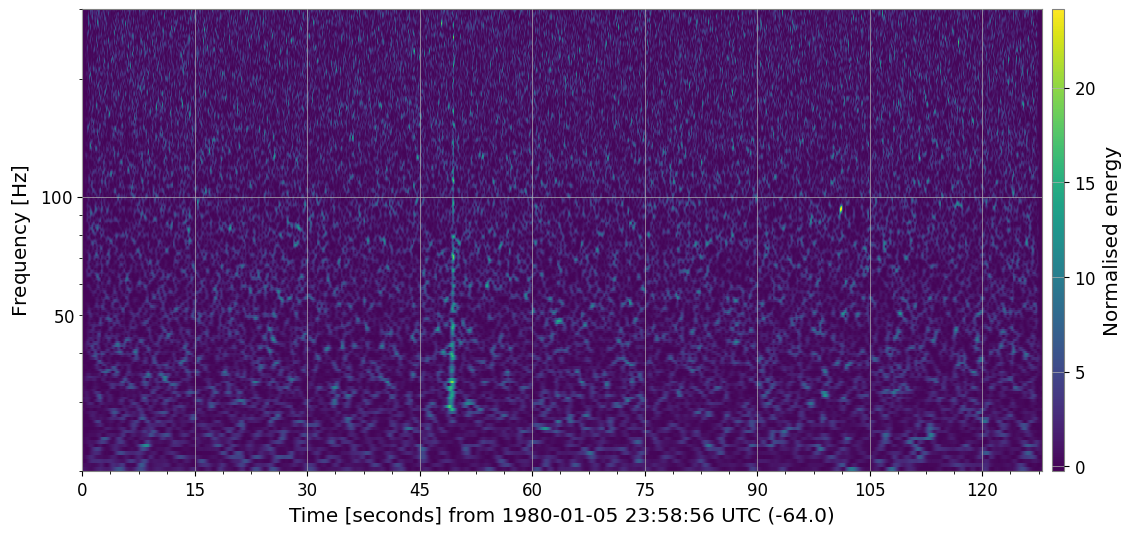

In [7]:
# plots the spectrogram of teh q transform
q = data.q_transform(frange=(20, 300), qrange=(100, 110))
plot = q.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

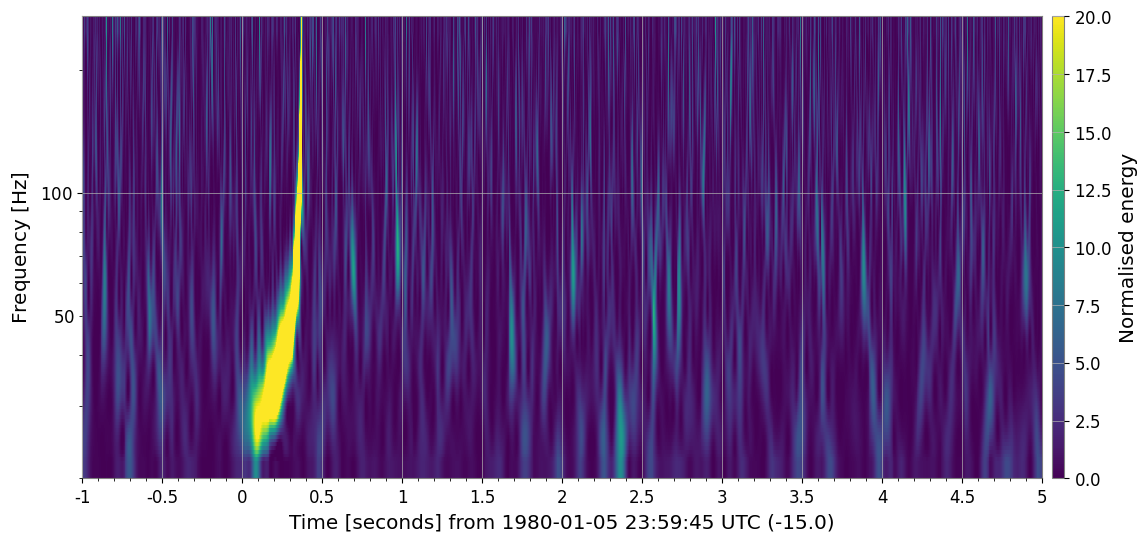

In [8]:
# since the data suggests the merger happened between t=45 and t=60 on the spectrogram, the scale is readjusted
#using the "outseg"; furthermore, the color limit is also readjusted
q = data.q_transform(frange=(20, 270), outseg=(-16, -10))
plot = q.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")
plot.colorbars[0].mappable.set_clim(0,20)


In [ ]:
# from the graph, the merger happens around t=0.4, but the x scale is set to be
# -15 s, so the actual merger happens at t=0.4-15=-14.6s

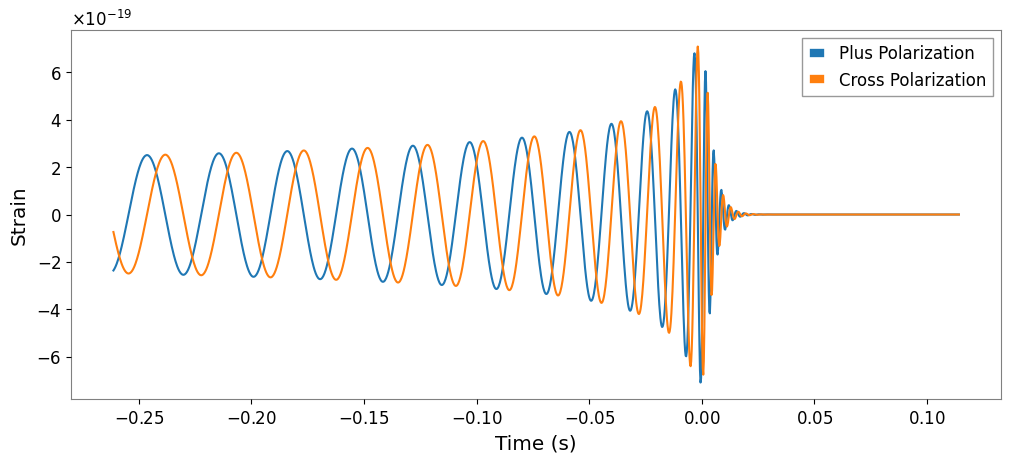

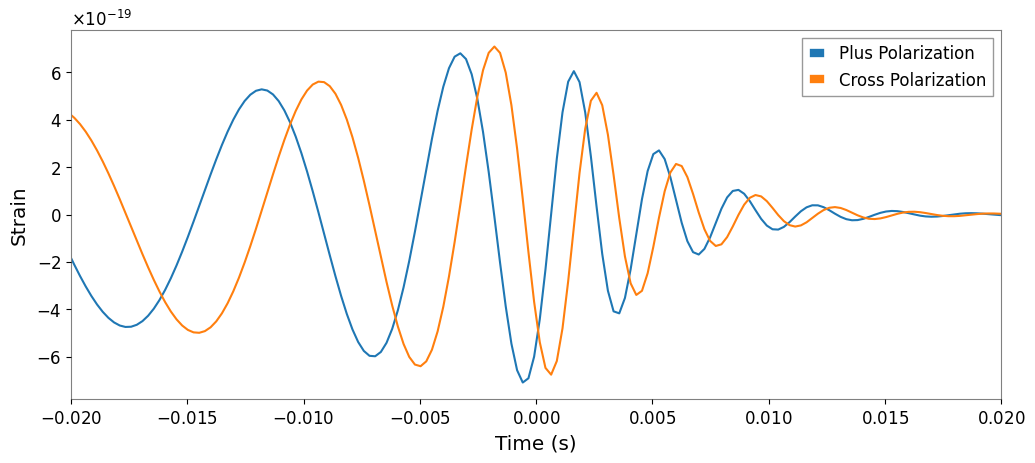

In [ ]:
# getting the packages requited to plot waveforms
%matplotlib inline
from pycbc.waveform import get_td_waveform
import pylab
# generating a waveform with mass 1 = mass 2 = 30 solar masses and spin = 0
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/sampling_rate,
                         f_lower=30)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

# zooms in near the merger time
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim(-.02, .02)
pylab.legend()
pylab.grid()
pylab.show()

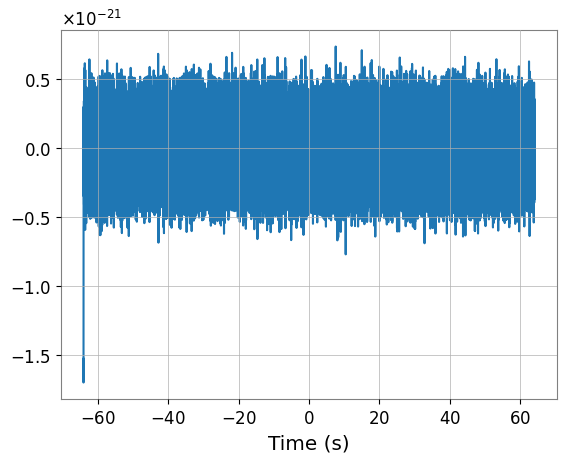

In [9]:
# this imports teh packages needed to plot and load the signal from the data
%matplotlib inline

import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc import frame
strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')

# this removes the low frequency content below 15 Hz; furthermore the data is
# downsampled to 2048Hz to increase the computation speed, however it creates a problem of
# noise at the beginning of the data - that is solved in the next step
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

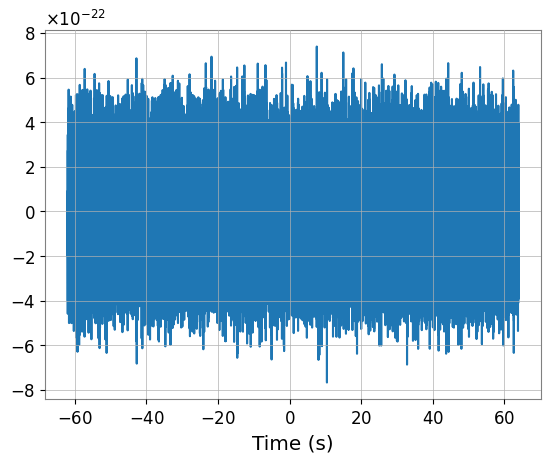

In [10]:
# this removes the data from end and begging to get rid of noise as mentioned
# in previous step
conditioned = strain.crop(2, 0)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [11]:
# imports things for calculating the PSD
from pycbc.psd import interpolate, inverse_spectrum_truncation

# this uses the welch method with 4 second samples
psd = conditioned.psd(4)

# we calculated PSD using welch method, but now we need to interpolate it
# and also limit the filter length to 1/PSD; after that we can finally use the PSD
# to filter the data in a controlled manner; also since the data has been high passed
# above 15 Hz, we need to inform the function to exclude the frequencies below that
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),low_frequency_cutoff=15)
print(psd)


[7.82364003e-41 7.86527676e-41 7.99116959e-41 ... 2.20057760e-48
 2.19468994e-48 2.19272936e-48]


(15, 1024)

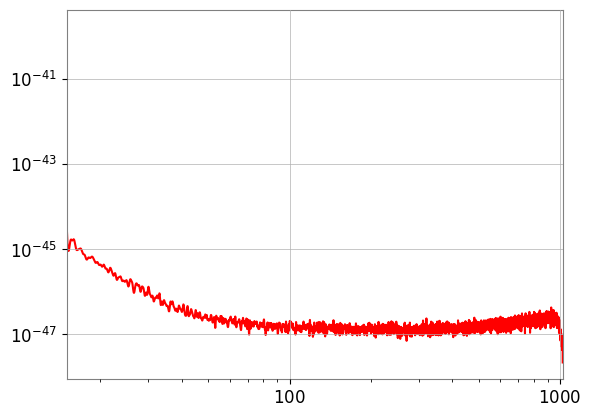

In [12]:
# this plots the PSD on a log log scale againt frequency
# the minimum frequency is 15 Hz (i know the assignment asked for 20 Hz, but my cutoff
# frequency was 15 Hz), and the maximum is Nyquist frequency which is half the sampling rate
# and since we downsampled to 2048 Hz, it's 1024 Hz
pylab.loglog(psd.sample_frequencies, psd, label="H1", color='r')
pylab.xlim(xmin=15, xmax=1024)

In [13]:
# here we generate a waveform again, but set the f_lower to 15 Hz, which is our cutoff frequency
# but this time we also use the conditioned.delta_t instead of 1/sampling rate
from pycbc.waveform import get_td_waveform

m = 30 #solar masses as stated in the exercise
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=15)

# this resizes  vector to match data
hp.resize(len(conditioned))

Text(0, 0.5, 'Strain')

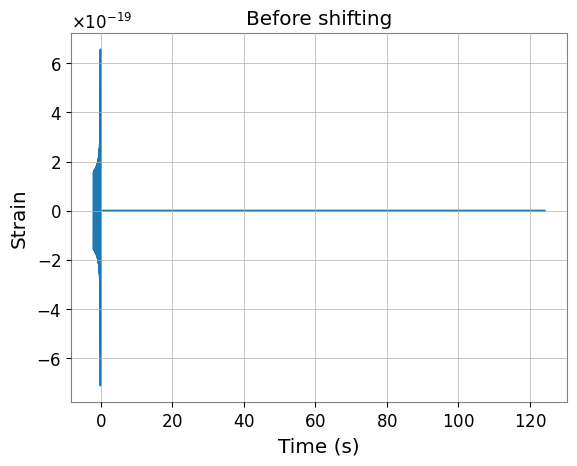

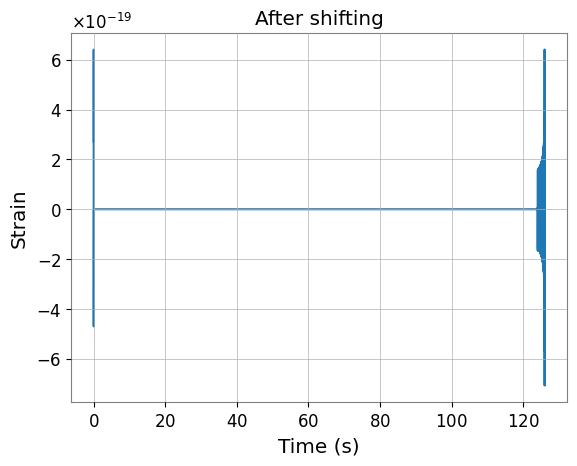

In [14]:
# here we plot the signal; we need to shift the data so that the merger is
# approximately at the first bin of the data
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

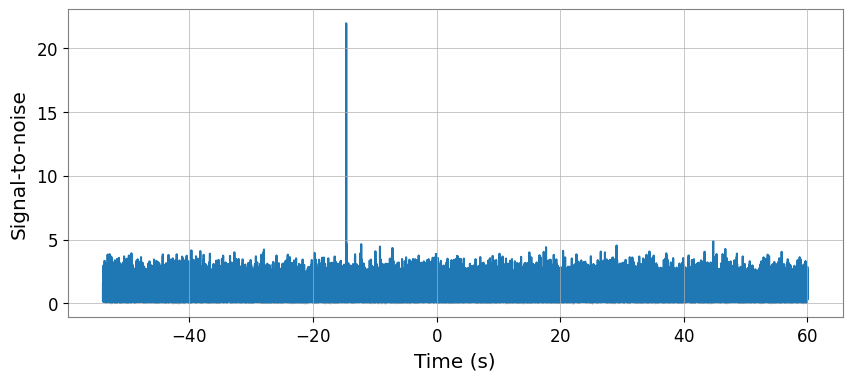

We found a signal at -14.6328125s with SNR 21.957272680087367


In [15]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# here we remove the time corruption by the template and psd filter
# by removing 4 seonds from the beginning and 4s seconds from end and
# 4 exrta seconds at the beginning in order to account for the template length
snr = snr.crop(4 + 4, 4)

# this plots
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

In [ ]:
# this is a very nice result since it also agrees with
# the approximate time of merger we found using the q-transform